In [ ]:
import matplotlib.pyplot as plt
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import Kan_NN
import importlib
importlib.reload(Kan_NN)

In [ ]:
path_kan = "CC_house_kan.dill"
path_NN = "CC_house_NN.dill"

In [21]:
import random
random.seed(42)
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
california_housing = fetch_california_housing(as_frame=True)
X = california_housing.data.values  # Convert DataFrame to NumPy array
y = california_housing.target.values.reshape(-1, 1)  # Reshape target to match PyTorch format

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features for better training stability
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders with batch size
batch_size = 1024  # Set batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
batch_test = 1
test_loader = DataLoader(test_dataset, batch_size=batch_test, shuffle=False)


# Check a sample batch
for batch in train_loader:
    X_batch, y_batch = batch
    print(f"Batch X shape: {X_batch.shape}, Batch y shape: {y_batch.shape}")
    break  # Print only one batch for verification


Batch X shape: torch.Size([1024, 8]), Batch y shape: torch.Size([1024, 1])


In [ ]:
@torch.no_grad()
def compute_test_loss(test_loader, model):
    criterion = torch.nn.MSELoss()
    running_loss = 0.
    for batch, target in test_loader:
        outputs = model(batch)
        loss = criterion(target, outputs)
        running_loss += loss.item()
    return running_loss / len(test_loader)

In [ ]:
import dill
with open(path_NN, "rb") as f:
    models_NN = dill.load(f)
with open(path_kan, "rb") as f:
    models_kan = dill.load(f)

Neural_Kan(
  (layers): Sequential(
    (0): SparseNeuralNetwork(
      (univariate_nn): Sequential(
        (0): Linear(
          (Lin_layer): Linear(in_features=8, out_features=2048, bias=True)
        )
        (1): ReLU()
      )
      (fc2): Linear(
        (Lin_layer): Linear(in_features=2048, out_features=8, bias=True)
      )
    )
    (1): SparseNeuralNetwork(
      (univariate_nn): Sequential(
        (0): Linear(
          (Lin_layer): Linear(in_features=8, out_features=2048, bias=True)
        )
        (1): ReLU()
      )
      (fc2): Linear(
        (Lin_layer): Linear(in_features=2048, out_features=8, bias=True)
      )
    )
    (2): SparseNeuralNetwork(
      (univariate_nn): Sequential(
        (0): Linear(
          (Lin_layer): Linear(in_features=8, out_features=256, bias=True)
        )
        (1): ReLU()
      )
      (fc2): Linear(
        (Lin_layer): Linear(in_features=256, out_features=1, bias=True)
      )
    )
  )
)


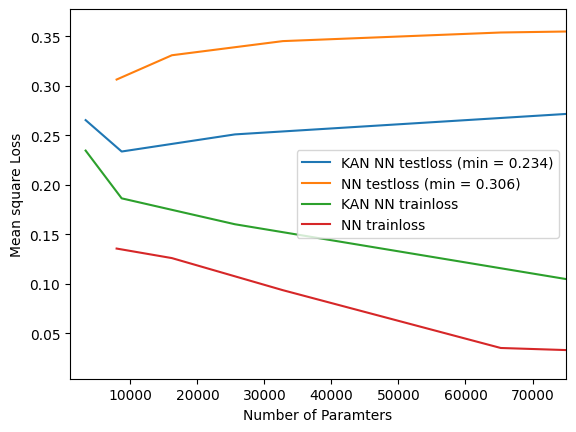

In [ ]:
criterion = torch.nn.MSELoss(reduction='mean')
max_depth = 2
for i in range(1,max_depth):
    plot_x =[]
    plot_y = []
    plot_x_NN =[]
    plot_y_NN = []
    plot_y_train = []
    plot_y_NN_train = []
    for model in models_kan[i - 1]:
        model.eval()
        loss_train = compute_test_loss(train_loader, model)
        plot_y_train.append(loss_train)
        loss = compute_test_loss(test_loader, model)
        plot_x.append(model.params)
        plot_y.append(loss)
    for model in models_NN[i - 2]:
        model.eval()
        loss_train = compute_test_loss(train_loader, model)
        plot_y_NN_train.append(loss_train)
        loss = compute_test_loss(test_loader, model)
        plot_x_NN.append(model.params)
        plot_y_NN.append(loss)
    plt.xlabel("Number of Paramters")
    plt.ylabel("Mean square Loss")
    plt.title(rf"Parameter Efficiency of KAN NN (Univariate Depth = {i}) vs. NN (depth={len(shape) + (len(shape)-1)*i}) in Approximating Polynomial $p \in P_2[I^4]$ ")
    plt.plot(plot_x, plot_y, label= f"KAN NN testloss (min = {min(plot_y):.3f})")
    plt.plot(plot_x_NN, plot_y_NN, label= f"NN testloss (min = {min(plot_y_NN):.3f})")
    plt.plot(plot_x, plot_y_train, label= f"KAN NN trainloss")
    plt.plot(plot_x_NN, plot_y_NN_train, label= f"NN trainloss")
    plt.xlim([1000, 75000])
    plt.legend()
    plt.show()